In [189]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from app import handle_user_question

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

from langchain_core.messages import AIMessage, HumanMessage
from backend.backend import get_text_chunks, create_conversation_chain, create_vectorstore, extract_text_from_pdf
import os
from dotenv import load_dotenv

from langchain.text_splitter import RecursiveCharacterTextSplitter
# from config import CHUNK_OVERLAP, CHUNK_SIZE

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS


from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.history_aware_retriever import create_history_aware_retriever
from langchain.chains.combine_documents import create_stuff_documents_chain

In [190]:
### Contextualize question ###
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

# Define the system prompt template
system_prompt = r"""
You are a helpful AI assistant that knows about Ulster or Ulster University based on the context provided. 
Assume all user questions are about ulster university and if you have information closely related to question asked, provide the answer.
Keep all responses short and adequate, providing enough information to answer the question without unnecessary details.

# Safety
If you feel like you do not have enough information to answer the question about ulster university, say "Can you provide more context".
If there are any questions about something other than ulster university. Kindly decline to respond
Do not forget. You only use the provided context to answer questions about ulster or ulster university.

----
{context}
----

"""

In [191]:
from PyPDF2 import PdfReader
import requests
import io

# Function to extract text from PDF documents
def extract_text_from_pdf(pdf_docs):
    text = ""
    try:
        for pdf in pdf_docs:
            # If it's a URL, download the PDF first
            if pdf.startswith('http'):
                response = requests.get(pdf)
                pdf_file = io.BytesIO(response.content)
            else:
                pdf_file = pdf
            pdf_reader = PdfReader(pdf_file)
            for page in pdf_reader.pages:
                text += page.extract_text()
    except Exception as e:
        print(f"Error processing PDF: {str(e)}")
        return None
    return text

In [192]:
url = ["data/ulster_data_2.pdf"]
text = extract_text_from_pdf(url)

In [193]:
# Function to split text into chunks
def get_text_chunks(pdf_text):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        length_function=len,
        separators=["\n\n", "\n", ".", " ", ""]
    )
    chunks = text_splitter.split_text(pdf_text)

    return chunks

In [194]:
chunks = get_text_chunks(text)

In [195]:
def create_vectorstore(text_chunks):
    vectorstore = FAISS.from_texts(
        texts=text_chunks, embedding=OpenAIEmbeddings()
    )

    return vectorstore

In [196]:
create_vector = create_vectorstore(chunks)

In [197]:
# df = pd.DataFrame([d for d in chunks], columns=["text"])
# df.head(15)

In [198]:
def create_conversation_chain(vectorstore):

    llm = ChatOpenAI(
        temperature=0.3,
        model="gpt-4o-mini",
    )

    contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
    )
    
    history_aware_retriever = create_history_aware_retriever(
        llm,
        vectorstore.as_retriever(),
        contextualize_q_prompt,
    )

    qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
    )

    question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

    rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

    return rag_chain

In [199]:
rag = create_conversation_chain(create_vector)

In [200]:
# rag.invoke({"input": "Is AI course available?", "chat_history": []})["answer"]

### CLASSIFIER

In [201]:
# # Load the Excel file into a DataFrame
# df = pd.read_excel("./ques_dup.xlsx")

# # Extract features
# questions = df['questions']
# answers = df['answers']  # Ensure the answers column is used
# lengths = df['lengths']
# labels = df['labels']

# # Vectorize questions
# vectorizer = TfidfVectorizer()
# question_embeddings = vectorizer.fit_transform(questions)

# # Combine question embeddings with lengths
# lengths = lengths.values.reshape(-1, 1)
# combined_features = np.hstack((question_embeddings.toarray(), lengths))

# # Train the classifier
# classifier = LogisticRegression()
# classifier.fit(combined_features, labels)

### RAG_HYBRID

In [202]:
# print(questions.to_list())

In [203]:
# def handle_user_question(user_question):
#     # Classify the user's question
#     user_question_embedding = vectorizer.transform([user_question])
#     user_question_length = np.array([[len(user_question)]])
#     user_combined_features = np.hstack((user_question_embedding.toarray(), user_question_length))
    
#     is_faq = classifier.predict(user_combined_features)[0]

#     if is_faq:
#         # FAQ handling
#         similarities = cosine_similarity(user_question_embedding, question_embeddings).flatten()
#         best_match_index = np.argmax(similarities)
#         best_match_score = similarities[best_match_index]

#         if best_match_score > 0.8:
#             response_text = answers.iloc[best_match_index]  # Fetch the corresponding answer
#             # print(response_text)
#         else:
#             response = rag.invoke({"input": user_question, "chat_history": []})
#             response_text = response['answer']

#     else:
#         # Non-FAQ handling using RAG pipeline
#         response = rag.invoke({"input": user_question, "chat_history": []})
#         response_text = response['answer']

#     return response_text

In [204]:
### RAG_ONLY

### RAG ONLY

In [205]:
def handle_user_question(user_question):
    response = rag.invoke({"input": user_question, "chat_history": []})
    response_text = response['answer']

    return response_text

In [206]:
# Initialize an empty list to store latencies
latencies = []

def measure_latency(user_question):
    # Start timing
    start_time = time.time()
    # print(start_time)
    
    # Handle the user question (replace with your actual logic)
    handle_user_question(user_question)
    
    # End timing
    end_time = time.time()
    # print(end_time)

    # Calculate latency
    latency = end_time - start_time
    latencies.append(latency)

In [207]:
# Example usage with sample questions
# sample_questions = ["How do I access course materials?", "Is AI course available?", "Can I study part-time in computing?", "What is the fee for MSc AI course?"]
from tqdm.auto import tqdm


for question in tqdm(questions.to_list()):
    measure_latency(question)

print(latencies)
# # Convert latencies to a DataFrame
# latency_df = pd.DataFrame(latencies, columns=['Latency'])

# # Plotting the latencies
# plt.figure(figsize=(10, 6))
# sns.histplot(latency_df['Latency'], kde=True)
# plt.title('Latency Distribution')
# plt.xlabel('Latency (seconds)')
# plt.ylabel('Frequency')
# plt.show()

# # Plot latency for each question
# plt.figure(figsize=(10, 6))
# plt.plot(latency_df['Latency'], marker='o')
# plt.title('Latency per Question')
# plt.xlabel('Question Number')
# plt.ylabel('Latency (seconds)')
# plt.show()



100%|██████████| 100/100 [02:39<00:00,  1.60s/it]

[1.6251506805419922, 1.0235445499420166, 1.5278816223144531, 1.3379313945770264, 1.331667184829712, 1.8404767513275146, 1.3305559158325195, 1.0238523483276367, 5.220047235488892, 1.1449356079101562, 6.5366106033325195, 1.3274407386779785, 1.1272599697113037, 1.7406082153320312, 1.0221972465515137, 1.2221848964691162, 5.5340094566345215, 1.3297531604766846, 1.2215654850006104, 1.0864439010620117, 1.1716058254241943, 1.0104570388793945, 1.1383774280548096, 1.5279862880706787, 2.5591471195220947, 1.2355268001556396, 1.2960567474365234, 1.3652355670928955, 1.227220058441162, 1.1272592544555664, 1.0167014598846436, 1.1214728355407715, 1.4414513111114502, 1.3317489624023438, 1.5338327884674072, 1.0234544277191162, 0.7971997261047363, 1.4544212818145752, 1.0213241577148438, 1.2702648639678955, 1.1792829036712646, 1.1700379848480225, 2.010702610015869, 1.1192231178283691, 1.439061164855957, 1.0217328071594238, 1.221435308456421, 1.0297691822052002, 1.6389942169189453, 1.2727551460266113, 1.286

In [208]:
# import random

# # Convert questions to a list and shuffle
# shuffled_questions = questions.to_list()
# random.shuffle(shuffled_questions)

# # Measure latency for shuffled questions
# for question in shuffled_questions:
#     measure_latency(question)

# # Convert latencies to a DataFrame
# latency_df = pd.DataFrame(latencies, columns=['Latency'])

# # Plotting the latencies
# plt.figure(figsize=(10, 6))
# sns.histplot(latency_df['Latency'], kde=True)
# plt.title('Latency Distribution')
# plt.xlabel('Latency (seconds)')
# plt.ylabel('Frequency')
# plt.show()

# # Plot latency for each question
# plt.figure(figsize=(10, 6))
# plt.plot(latency_df['Latency'], marker='o')
# plt.title('Latency per Question')
# plt.xlabel('Question Number')
# plt.ylabel('Latency (seconds)')
# plt.show()

In [209]:
# hist = []

# for que in tqdm(data):
#     res = rag.invoke({"input": que['question'], "chat_history": hist})
#     res['chat_history'].extend(
#         [
#             HumanMessage(content=res['input']),
#             AIMessage(content=res['answer']),
#         ]
#     )
    
#     hist = res['chat_history']

In [210]:
# import random
# # import pandas as pd
# # import matplotlib.pyplot as plt

# # Shuffle questions
# shuffled_questions = questions.to_list()
# random.shuffle(shuffled_questions)

# # Measure latency for shuffled questions
# for question in shuffled_questions:
#     measure_latency(question)

# # Convert latencies to a DataFrame
# latency_df = pd.DataFrame(latencies, columns=['Latency'])

# # Plotting the latencies using a line plot (Latency Distribution)
# plt.figure(figsize=(10, 6))
# plt.plot(sorted(latency_df['Latency']), marker='o', linestyle='-', label='Latency Distribution')
# plt.title('Latency Distribution (Line Plot)')
# plt.xlabel('Samples (sorted)')
# plt.ylabel('Latency (seconds)')
# plt.legend()
# plt.grid()
# plt.show()

# # Plot latency for each question using a line plot
# plt.figure(figsize=(10, 6))
# plt.plot(latency_df['Latency'], marker='o', linestyle='-', label='Latency per Question')
# plt.title('Latency per Question (Line Plot)')
# plt.xlabel('Question Number')
# plt.ylabel('Latency (seconds)')
# plt.legend()
# plt.grid()
# plt.show()


In [221]:
RAG_HYBRID = [0.004839897155761719, 0.001886606216430664, 0.0006883144378662109, 0.0006225109100341797, 0.002902984619140625, 0.0007710456848144531, 0.0023131370544433594, 0.0006272792816162109, 0.0006055831909179688, 0.0006136894226074219, 0.0006241798400878906, 0.0006313323974609375, 0.002046823501586914, 0.0007598400115966797, 0.0005583763122558594, 0.0006546974182128906, 0.000850677490234375, 0.0009350776672363281, 0.0005085468292236328, 0.00048732757568359375, 0.00047588348388671875, 0.00046133995056152344, 0.0005273818969726562, 0.0004684925079345703, 0.0004467964172363281, 0.00044798851013183594, 0.0004508495330810547, 0.0005345344543457031, 0.0006570816040039062, 0.0007305145263671875, 0.0008356571197509766, 0.0005812644958496094, 0.0004966259002685547, 0.00048661231994628906, 0.0004742145538330078, 0.0004591941833496094, 0.00047588348388671875, 0.00045943260192871094, 0.00046706199645996094, 0.0004487037658691406, 0.00045680999755859375, 0.00044035911560058594, 0.0007781982421875, 0.0010082721710205078, 0.0006234645843505859, 0.0005440711975097656, 0.0005271434783935547, 0.0005383491516113281, 0.0008080005645751953, 0.0006284713745117188, 0.0005609989166259766, 0.0004742145538330078, 0.00046539306640625, 0.0005862712860107422, 0.0004878044128417969, 0.00046539306640625, 0.0004544258117675781, 1.3015592098236084, 1.3068532943725586, 2.219090461730957, 1.7770261764526367, 1.43267822265625, 2.56242299079895, 2.45528507232666, 2.049375295639038, 1.5359070301055908, 1.2268486022949219, 1.7756221294403076, 1.26535964012146, 2.5551555156707764, 1.239825963973999, 1.5003414154052734, 1.839143991470337, 1.5349488258361816, 1.943650245666504, 1.706088542938232, 2.1508889198303223, 1.603407859802246, 2.3891539573669434, 1.5357367992401123, 1.639805793762207, 1.227480411529541, 1.4353294372558594, 1.4191129207611084, 1.30744457244873, 1.9461805820465088, 1.535569429397583, 1.6386497020721436, 1.434227705001831, 1.433354377746582, 1.2288143634796143, 1.222165584564209, 1.7473158836364746, 1.1275198459625244, 1.816011905670166, 1.6264207363128662, 2.2409064769744873, 1.4468159675598145, 1.3312864303588867, 1.3310887813568115]

In [216]:
RAG_ONLY = [1.6251506805419922, 1.0235445499420166, 1.5278816223144531, 1.3379313945770264, 1.331667184829712, 1.8404767513275146, 1.3305559158325195, 1.0238523483276367, 5.220047235488892, 1.1449356079101562, 6.5366106033325195, 1.3274407386779785, 1.1272599697113037, 1.7406082153320312, 1.0221972465515137, 1.2221848964691162, 5.5340094566345215, 1.3297531604766846, 1.2215654850006104, 1.0864439010620117, 1.1716058254241943, 1.0104570388793945, 1.1383774280548096, 1.5279862880706787, 2.5591471195220947, 1.2355268001556396, 1.2960567474365234, 1.3652355670928955, 1.227220058441162, 1.1272592544555664, 1.0167014598846436, 1.1214728355407715, 1.4414513111114502, 1.3317489624023438, 1.5338327884674072, 1.0234544277191162, 0.7971997261047363, 1.4544212818145752, 1.0213241577148438, 1.2702648639678955, 1.1792829036712646, 1.1700379848480225, 2.010702610015869, 1.1192231178283691, 1.439061164855957, 1.0217328071594238, 1.221435308456421, 1.0297691822052002, 1.6389942169189453, 1.2727551460266113, 1.2863373756408691, 1.8345139026641846, 3.7949700355529785, 1.3247365951538086, 1.5392115116119385, 1.3316702842712402, 1.4335832595825195, 1.1272687911987305, 1.6340975761413574, 1.535193920135498, 1.429596185684204, 2.461522340774536, 2.866609811782837, 2.2459566593170166, 1.2314262390136719, 1.3333604335784912, 1.363337755203247, 1.6493065357208252, 2.3094465732574463, 1.637495756149292, 1.739476203918457, 1.3206746578216553, 1.2868986129760742, 1.3079686164855957, 1.4055595397949219, 1.041541337966919, 1.721743106842041, 2.1512060165405273, 1.2261567115783691, 1.4342882633209229, 1.2063775062561035, 1.5255658626556396, 1.3178117275238037, 2.0973446369171143, 1.3232860565185547, 1.4330358505249023, 1.7391676902770996, 1.8436369895935059, 1.637228012084961, 2.662719964981079, 1.5331878662109375, 1.5361824035644531, 1.8420512676239014, 1.2278540134429932, 1.1265816688537598, 1.3316237926483154, 1.6359281539916992, 1.3313610553741455, 1.6315076351165771, 1.1318225860595703]

In [218]:
# len(RAG_HYBRID)
# # len(RAG_ONLY)

100

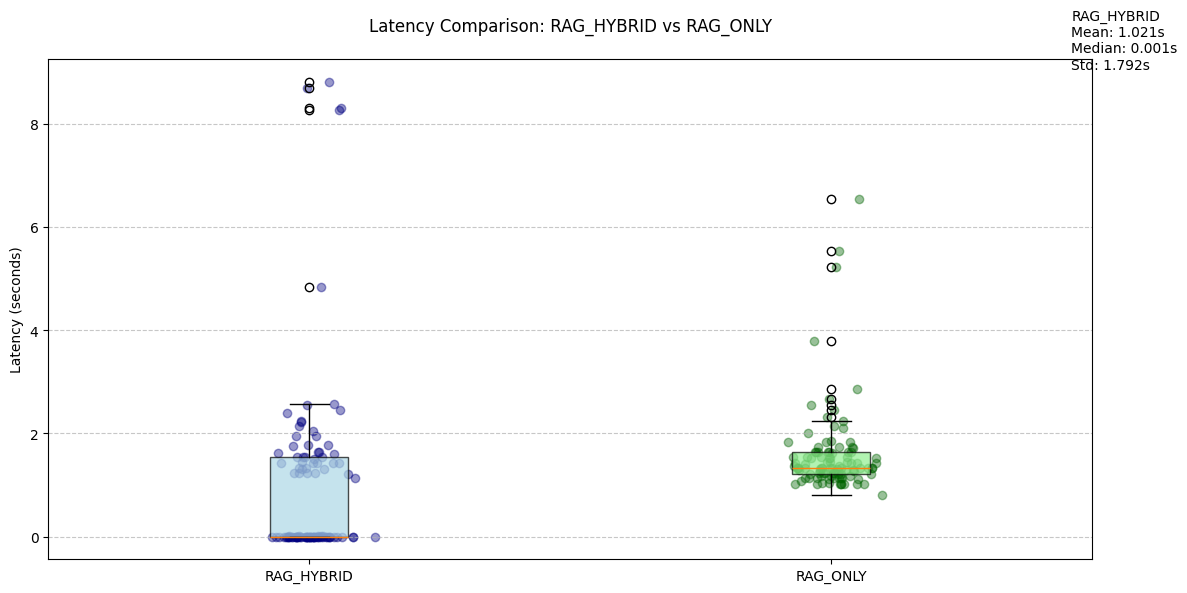

In [219]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axis
plt.figure(figsize=(12, 6))

# Create box plots
box_positions = [1, 2]
box_data = [RAG_HYBRID, RAG_ONLY]
bp = plt.boxplot(box_data, positions=box_positions, patch_artist=True)

# Customize box plots
colors = ['lightblue', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add scatter plots (jittered for better visibility)
for i, data in enumerate([RAG_HYBRID, RAG_ONLY], 1):
    # Create jitter
    jitter = np.random.normal(0, 0.04, size=len(data))
    plt.scatter(jitter + i, data, alpha=0.4, color='navy' if i==1 else 'darkgreen')

# Customize the plot
plt.title('Latency Comparison: RAG_HYBRID vs RAG_ONLY', pad=20)
plt.ylabel('Latency (seconds)')
plt.xticks(box_positions, ['RAG_HYBRID', 'RAG_ONLY'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add statistical information
plt.text(0.98, 1.1, f'RAG_HYBRID\nMean: {np.mean(RAG_HYBRID):.3f}s\nMedian: {np.median(RAG_HYBRID):.3f}s\nStd: {np.std(RAG_HYBRID):.3f}s', 
        transform=plt.gca().transAxes, verticalalignment='top')

# Adjust layout and display
plt.tight_layout()

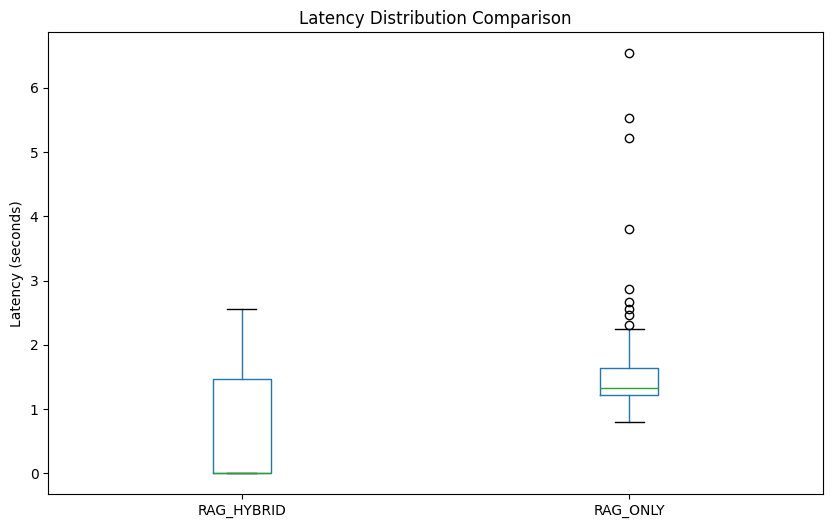

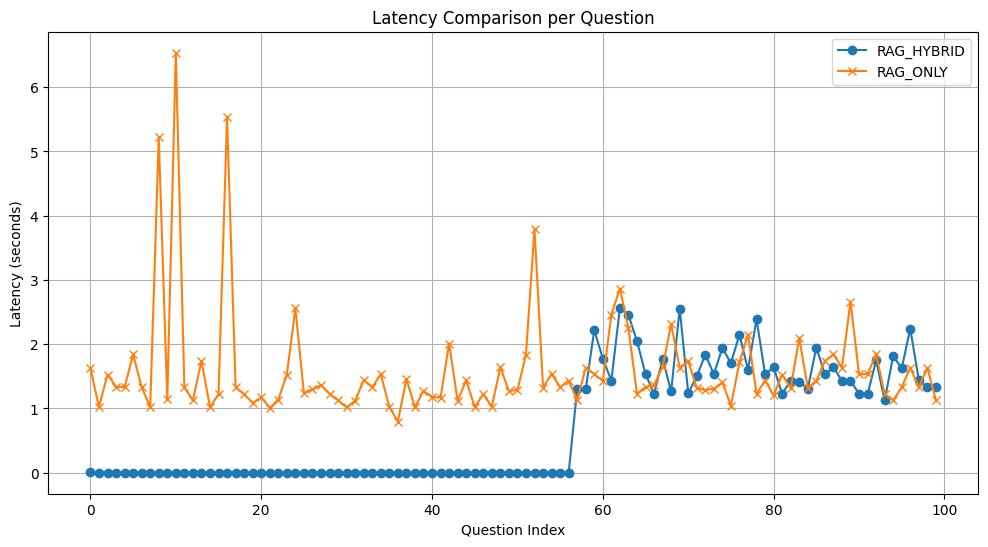

In [222]:
# Create a DataFrame for plotting
data = pd.DataFrame({
    'RAG_HYBRID': RAG_HYBRID,
    'RAG_ONLY': RAG_ONLY
})

# Box plot for latency distribution
plt.figure(figsize=(10, 6))
data.boxplot()
plt.title('Latency Distribution Comparison')
plt.ylabel('Latency (seconds)')
plt.grid()
plt.show()

# Line plot for side-by-side latency comparison
plt.figure(figsize=(12, 6))
plt.plot(data['RAG_HYBRID'], label='RAG_HYBRID', marker='o')
plt.plot(data['RAG_ONLY'], label='RAG_ONLY', marker='x')
plt.title('Latency Comparison per Question')
plt.xlabel('Question Index')
plt.ylabel('Latency (seconds)')
plt.legend()
plt.grid()
plt.show()

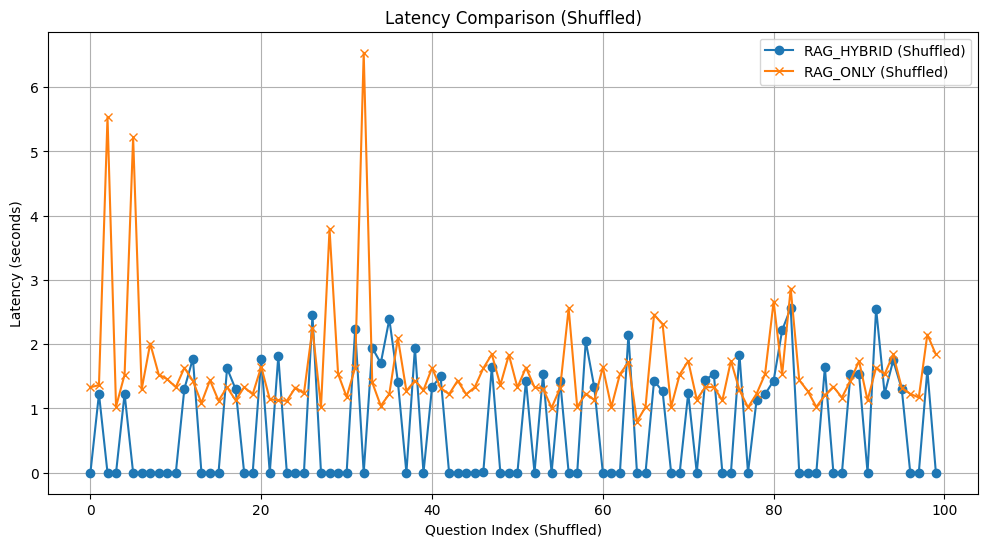

In [223]:
# Ensure both lists have the same length
assert len(RAG_HYBRID) == len(RAG_ONLY), "Both datasets must have the same number of elements."

# Generate a random permutation index
random_indices = np.random.permutation(len(RAG_HYBRID))

# Shuffle both lists using the same random indices
RAG_HYBRID_shuffled = [RAG_HYBRID[i] for i in random_indices]
RAG_ONLY_shuffled = [RAG_ONLY[i] for i in random_indices]

# Combine into a DataFrame for visualization
data = pd.DataFrame({
    'RAG_HYBRID': RAG_HYBRID_shuffled,
    'RAG_ONLY': RAG_ONLY_shuffled
})

# Visualize the shuffled data (optional example plot)
plt.figure(figsize=(12, 6))
plt.plot(data['RAG_HYBRID'], label='RAG_HYBRID (Shuffled)', marker='o')
plt.plot(data['RAG_ONLY'], label='RAG_ONLY (Shuffled)', marker='x')
plt.title('Latency Comparison (Shuffled)')
plt.xlabel('Question Index (Shuffled)')
plt.ylabel('Latency (seconds)')
plt.legend()
plt.grid()
plt.show()

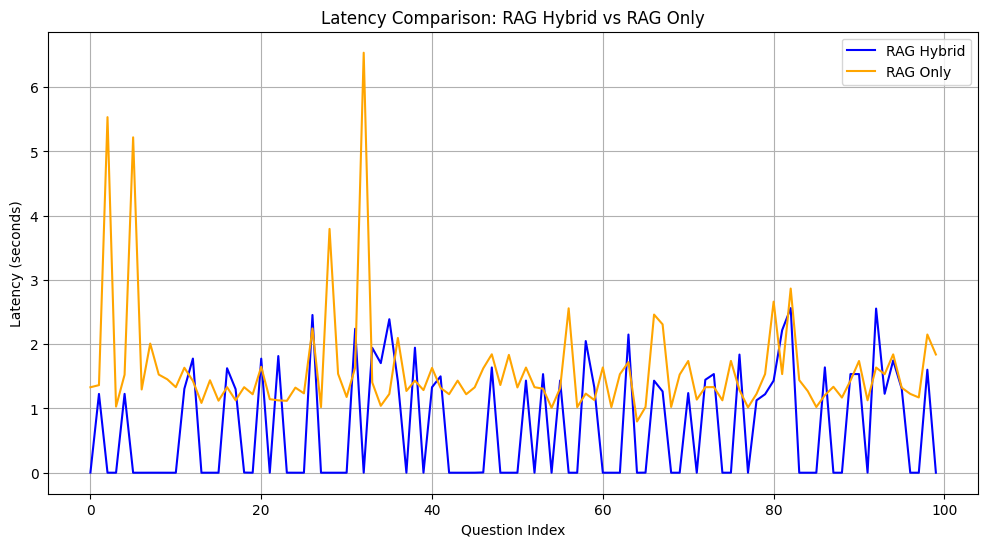

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming RAG_HYBRID_shuffled and RAG_ONLY_shuffled are already defined
# Create x-axis indices
x_values = np.arange(len(RAG_HYBRID_shuffled))

# Plot the curve line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=x_values, y=RAG_HYBRID_shuffled, label="RAG Hybrid", color="blue")
sns.lineplot(x=x_values, y=RAG_ONLY_shuffled, label="RAG Only",  color="orange")
plt.title("Latency Comparison: RAG Hybrid vs RAG Only")
plt.xlabel("Question Index")
plt.ylabel("Latency (seconds)")
plt.legend()
plt.grid(True)
plt.show()

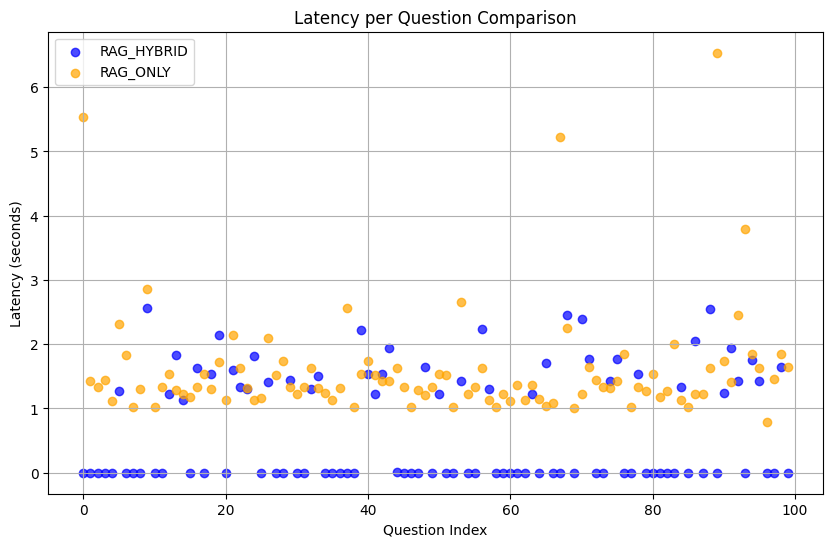

In [231]:
# Ensure both lists have the same length
assert len(RAG_HYBRID) == len(RAG_ONLY), "Both datasets must have the same number of elements."

# Generate a random permutation index
random_indices = np.random.permutation(len(RAG_HYBRID))

# Shuffle both lists using the same random indices
RAG_HYBRID_shuffled = [RAG_HYBRID[i] for i in random_indices]
RAG_ONLY_shuffled = [RAG_ONLY[i] for i in random_indices]

# Combine into a DataFrame for visualization
data = pd.DataFrame({
    'RAG_HYBRID': RAG_HYBRID_shuffled,
    'RAG_ONLY': RAG_ONLY_shuffled
})

plt.figure(figsize=(10, 6))
plt.scatter(range(len(RAG_HYBRID_shuffled)), RAG_HYBRID_shuffled, label='RAG_HYBRID', color='blue', alpha=0.7)
plt.scatter(range(len(RAG_ONLY_shuffled)), RAG_ONLY_shuffled, label='RAG_ONLY', color='orange', alpha=0.7)
plt.title('Latency per Question Comparison')
plt.xlabel('Question Index')
plt.ylabel('Latency (seconds)')
plt.legend()
plt.grid()
plt.show()